In [1]:
import pandas as pd

import sklearn.model_selection
import sklearn.compose
import sklearn.preprocessing
import sklearn.svm
from sklearn.metrics import mean_squared_error, r2_score
import sklearn.linear_model
import sklearn.ensemble

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Remember to come back to this and remove any that you didn't actually use.

## Step 0.1: Adding the XAI packages

In [2]:
!pip install shap
!pip install lime

In [3]:
import shap
shap.initjs()
import lime
import lime.lime_tabular

In [4]:
df = pd.read_csv('ds_salaries.csv')
display(df.head(21))
df.shape

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M
5,2023,SE,FT,Applied Scientist,222200,USD,222200,US,0,US,L
6,2023,SE,FT,Applied Scientist,136000,USD,136000,US,0,US,L
7,2023,SE,FT,Data Scientist,219000,USD,219000,CA,0,CA,M
8,2023,SE,FT,Data Scientist,141000,USD,141000,CA,0,CA,M
9,2023,SE,FT,Data Scientist,147100,USD,147100,US,0,US,M


(3755, 11)

In [5]:
print(df['experience_level'].unique())
print(df['employment_type'].unique())

['SE' 'MI' 'EN' 'EX']
['FT' 'CT' 'FL' 'PT']


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3755 entries, 0 to 3754
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           3755 non-null   int64 
 1   experience_level    3755 non-null   object
 2   employment_type     3755 non-null   object
 3   job_title           3755 non-null   object
 4   salary              3755 non-null   int64 
 5   salary_currency     3755 non-null   object
 6   salary_in_usd       3755 non-null   int64 
 7   employee_residence  3755 non-null   object
 8   remote_ratio        3755 non-null   int64 
 9   company_location    3755 non-null   object
 10  company_size        3755 non-null   object
dtypes: int64(4), object(7)
memory usage: 322.8+ KB


In [7]:
# I learned what the previews categories meant here: https://ai-jobs.net/salaries/download/
meanings = {'FT':'Full Time','CT':'Contract','FL':'Freelance','PT':'Part Time',
            'SE':'Senior-Level / Expert','MI':'Mid-Level / Intermediate',
            'EN':'Entry-Level / Junior','EX':'Executive-Level / Director'}
# Created this list to have in handy whenever I'm not sure what any of the code words mean.

In [8]:
df = df.drop(['work_year','salary','salary_currency','remote_ratio',
         'employee_residence','company_location'], axis = 1)
df.head(21)

,experience_level,employment_type,job_title,salary_in_usd,company_size
0,SE,FT,Principal Data Scientist,85847,L
1,MI,CT,ML Engineer,30000,S
2,MI,CT,ML Engineer,25500,S
3,SE,FT,Data Scientist,175000,M
4,SE,FT,Data Scientist,120000,M
5,SE,FT,Applied Scientist,222200,L
6,SE,FT,Applied Scientist,136000,L
7,SE,FT,Data Scientist,219000,M
8,SE,FT,Data Scientist,141000,M
9,SE,FT,Data Scientist,147100,M


In [9]:
df1 = df[(df['job_title'] == 'Data Engineer')]
df2 = df[(df['job_title'] == 'Data Scientist')]
df3 = df[(df['job_title'] == 'Data Analyst')]
df4 = df[(df['job_title'] == 'Machine Learning Engineer')]
df5 = df[(df['job_title'] == 'Analytics Engineer')]
df = pd.concat([df1,df2,df3,df4,df5])
print(df.shape)
df

(2884, 5)


,experience_level,employment_type,job_title,salary_in_usd,company_size
31,SE,FT,Data Engineer,253200,M
32,SE,FT,Data Engineer,90700,M
35,MI,FT,Data Engineer,162500,M
36,MI,FT,Data Engineer,130000,M
44,SE,FT,Data Engineer,270703,M
...,...,...,...,...,...
3086,EN,FT,Analytics Engineer,130000,L
3312,EX,FT,Analytics Engineer,175000,M
3313,EX,FT,Analytics Engineer,135000,M
3328,SE,FT,Analytics Engineer,205300,M


## We will add another column that divides the salaries into 4 different categories

In [10]:
# prompt: add a new column that divides the 'salary_in_usd' into: '> 100k', '100k < x <= 75k', '75k < x <= 50k', '< 50k'

df['salary_category'] = pd.cut(df['salary_in_usd'], bins=[0,50000,75000,100000,np.inf], labels=['< 50k','75k < x <= 50k','100k < x <= 75k','> 100k'])
df.head(21)


,experience_level,employment_type,job_title,salary_in_usd,company_size,salary_category
31,SE,FT,Data Engineer,253200,M,> 100k
32,SE,FT,Data Engineer,90700,M,100k < x <= 75k
35,MI,FT,Data Engineer,162500,M,> 100k
36,MI,FT,Data Engineer,130000,M,> 100k
44,SE,FT,Data Engineer,270703,M,> 100k
45,SE,FT,Data Engineer,221484,M,> 100k
54,SE,FT,Data Engineer,203300,M,> 100k
55,SE,FT,Data Engineer,123600,M,> 100k
60,SE,FT,Data Engineer,231500,M,> 100k
61,SE,FT,Data Engineer,166000,M,> 100k


In [11]:
dummy_df = pd.get_dummies(df, columns = ['experience_level','employment_type',
                                          'job_title','company_size'])

In [12]:
Label_Encoder = sklearn.preprocessing.LabelEncoder()

In [13]:
dummy_df['salary_category'] = Label_Encoder.fit_transform(dummy_df['salary_category'])

In [14]:
dummy_df

,salary_in_usd,salary_category,experience_level_EN,experience_level_EX,experience_level_MI,experience_level_SE,employment_type_CT,employment_type_FL,employment_type_FT,employment_type_PT,job_title_Analytics Engineer,job_title_Data Analyst,job_title_Data Engineer,job_title_Data Scientist,job_title_Machine Learning Engineer,company_size_L,company_size_M,company_size_S
31,253200,3,False,False,False,True,False,False,True,False,False,False,True,False,False,False,True,False
32,90700,0,False,False,False,True,False,False,True,False,False,False,True,False,False,False,True,False
35,162500,3,False,False,True,False,False,False,True,False,False,False,True,False,False,False,True,False
36,130000,3,False,False,True,False,False,False,True,False,False,False,True,False,False,False,True,False
44,270703,3,False,False,False,True,False,False,True,False,False,False,True,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3086,130000,3,True,False,False,False,False,False,True,False,True,False,False,False,False,True,False,False
3312,175000,3,False,True,False,False,False,False,True,False,True,False,False,False,False,False,True,False
3313,135000,3,False,True,False,False,False,False,True,False,True,False,False,False,False,False,True,False
3328,205300,3,False,False,False,True,False,False,True,False,True,False,False,False,False,False,True,False


In [15]:
# Show me all of the names of the columns
dummy_df.columns.to_list()

['salary_in_usd',
 'salary_category',
 'experience_level_EN',
 'experience_level_EX',
 'experience_level_MI',
 'experience_level_SE',
 'employment_type_CT',
 'employment_type_FL',
 'employment_type_FT',
 'employment_type_PT',
 'job_title_Analytics Engineer',
 'job_title_Data Analyst',
 'job_title_Data Engineer',
 'job_title_Data Scientist',
 'job_title_Machine Learning Engineer',
 'company_size_L',
 'company_size_M',
 'company_size_S']

<Axes: >

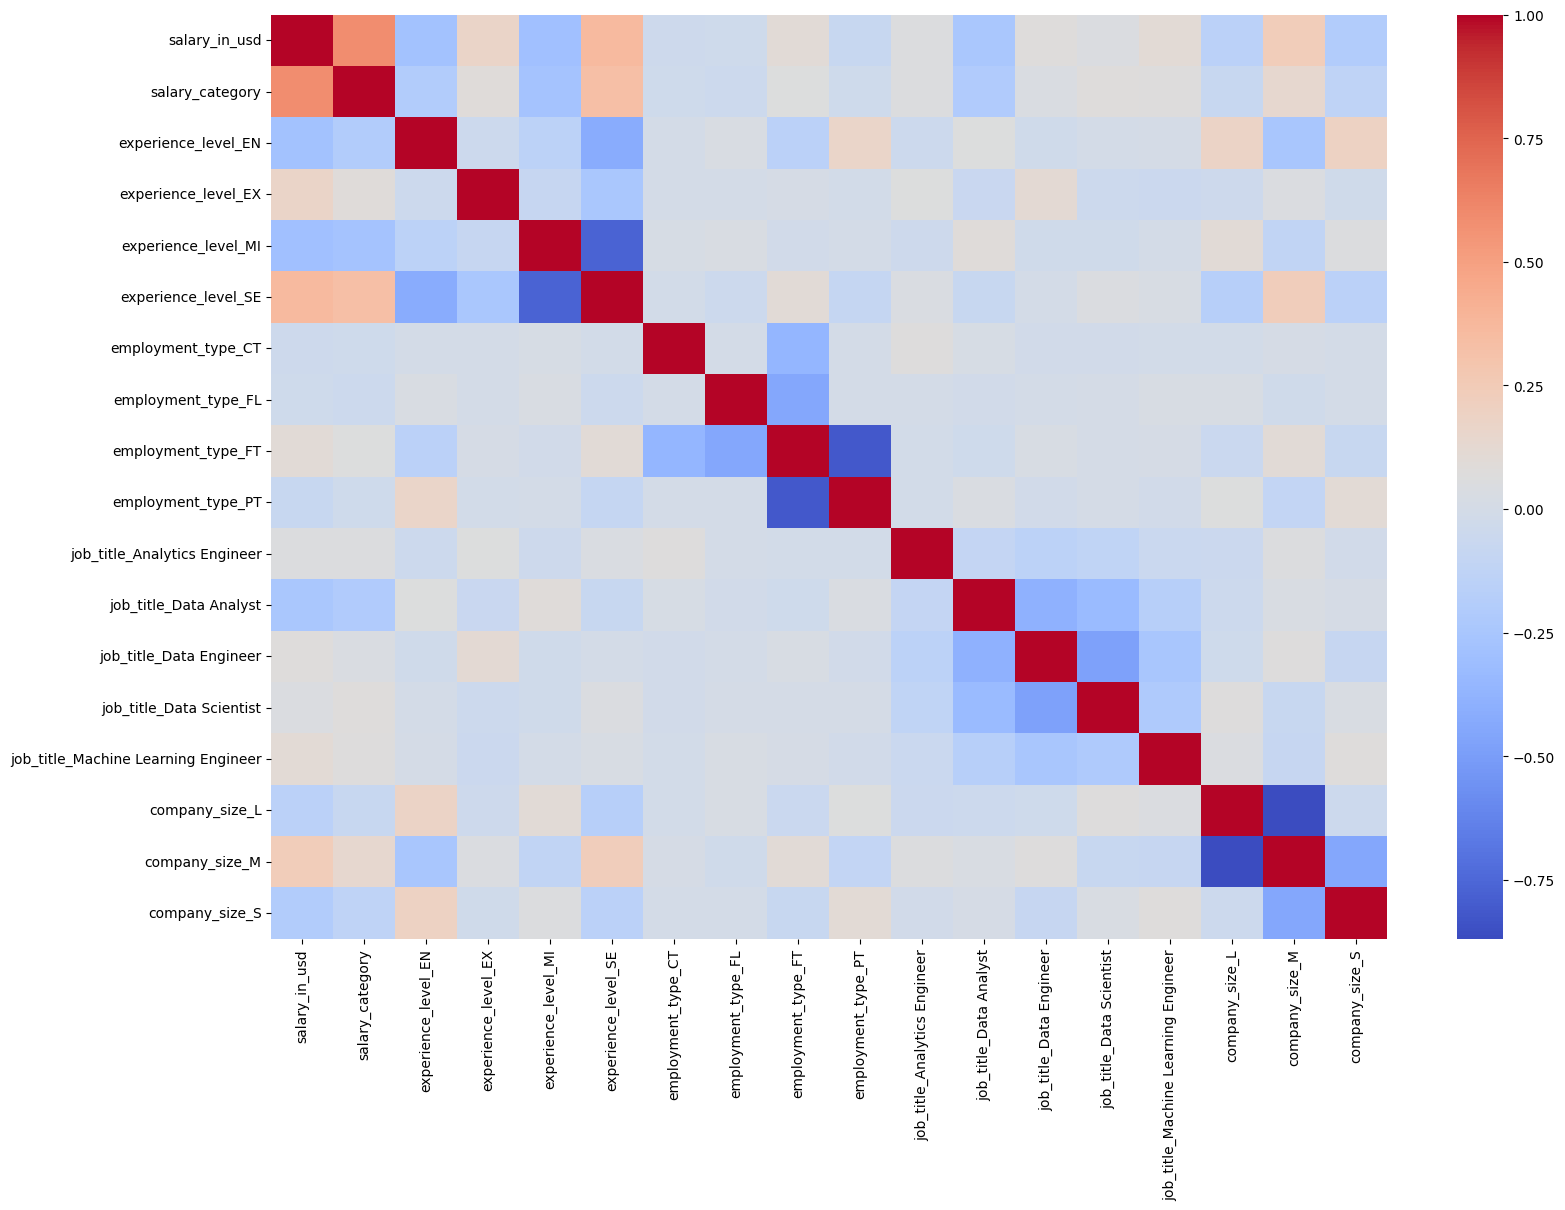

In [16]:
plt.figure(figsize = (18,12))
sns.heatmap(dummy_df.corr(), annot = False, cmap = 'coolwarm')

In [17]:
correlations = dummy_df.corr()['salary_in_usd'].abs()
sorted_correlations = correlations.sort_values()
num_cols_to_drop = int(0.8 * len(df.columns))
cols_to_drop = sorted_correlations.iloc[:num_cols_to_drop].index
df_dropped = dummy_df.drop(cols_to_drop, axis = 1)

In [18]:
df_dropped

,salary_in_usd,salary_category,experience_level_EN,experience_level_EX,experience_level_MI,experience_level_SE,employment_type_FT,employment_type_PT,job_title_Data Analyst,job_title_Data Engineer,job_title_Machine Learning Engineer,company_size_L,company_size_M,company_size_S
31,253200,3,False,False,False,True,True,False,False,True,False,False,True,False
32,90700,0,False,False,False,True,True,False,False,True,False,False,True,False
35,162500,3,False,False,True,False,True,False,False,True,False,False,True,False
36,130000,3,False,False,True,False,True,False,False,True,False,False,True,False
44,270703,3,False,False,False,True,True,False,False,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3086,130000,3,True,False,False,False,True,False,False,False,False,True,False,False
3312,175000,3,False,True,False,False,True,False,False,False,False,False,True,False
3313,135000,3,False,True,False,False,True,False,False,False,False,False,True,False
3328,205300,3,False,False,False,True,True,False,False,False,False,False,True,False


<Axes: >

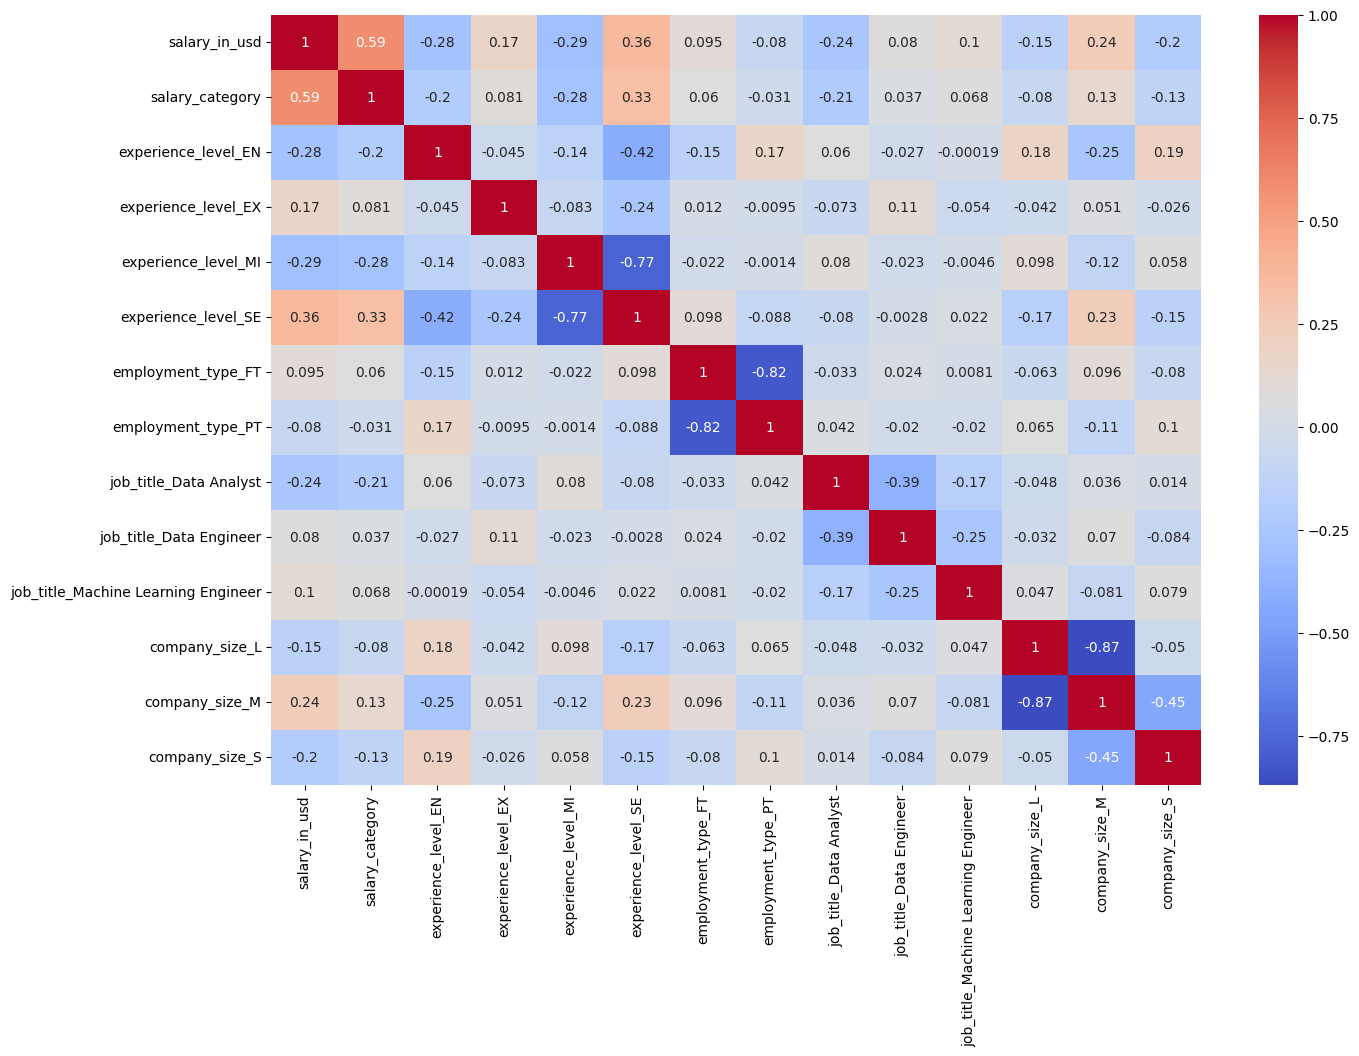

In [19]:
plt.figure(figsize = (15,10))
sns.heatmap(df_dropped.corr(), annot = True, cmap = 'coolwarm')

#####################################################################

In [20]:
df_train, df_test = sklearn.model_selection.train_test_split(dummy_df)
print(f'DF size: {dummy_df.shape}')
print(f'DF Train size: {df_train.shape}')
print(f'DF Test size: {df_test.shape}')

DF size: (2884, 18)
DF Train size: (2163, 18)
DF Test size: (721, 18)


In [21]:
df_train.isnull().sum()

,0
salary_in_usd,0
salary_category,0
experience_level_EN,0
experience_level_EX,0
experience_level_MI,0
experience_level_SE,0
employment_type_CT,0
employment_type_FL,0
employment_type_FT,0
employment_type_PT,0


In [22]:
df_train.isna().sum()

,0
salary_in_usd,0
salary_category,0
experience_level_EN,0
experience_level_EX,0
experience_level_MI,0
experience_level_SE,0
employment_type_CT,0
employment_type_FL,0
employment_type_FT,0
employment_type_PT,0


In [23]:
x_train = df_train.drop(['salary_in_usd','salary_category'], axis = 1)
y_train = df_train['salary_category']

x_test = df_test.drop(['salary_in_usd','salary_category'], axis = 1)
y_test = df_test['salary_category']

###########################

print('x_train size: ', x_train.shape)
print('y_train size: ', y_train.shape)

print('x_test size: ', x_test.shape)
print('y_test size: ', y_test.shape)

x_train size:  (2163, 16)
y_train size:  (2163,)
x_test size:  (721, 16)
y_test size:  (721,)


In [24]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2163 entries, 691 to 3114
Data columns (total 16 columns):
 #   Column                               Non-Null Count  Dtype
---  ------                               --------------  -----
 0   experience_level_EN                  2163 non-null   bool 
 1   experience_level_EX                  2163 non-null   bool 
 2   experience_level_MI                  2163 non-null   bool 
 3   experience_level_SE                  2163 non-null   bool 
 4   employment_type_CT                   2163 non-null   bool 
 5   employment_type_FL                   2163 non-null   bool 
 6   employment_type_FT                   2163 non-null   bool 
 7   employment_type_PT                   2163 non-null   bool 
 8   job_title_Analytics Engineer         2163 non-null   bool 
 9   job_title_Data Analyst               2163 non-null   bool 
 10  job_title_Data Engineer              2163 non-null   bool 
 11  job_title_Data Scientist             2163 non-null   bool 


In [ ]:
#categorical_attributes = x_train.select_dtypes(include = ['object']).columns.tolist()
#numerical_attributes = x_train.select_dtypes(include = ['int64']).columns.tolist()
#ct = sklearn.compose.ColumnTransformer([
 #    ('standard_scaling', sklearn.preprocessing.StandardScaler(), numerical_attributes),
  #   ('one_hot_encoding', sklearn.preprocessing.OneHotEncoder(handle_unknown = 'ignore'), categorical_attributes),
 #])

# ct.fit(x_train)
# x_train = ct.transform(x_train)
# x_test = ct.transform(x_test)

# print ('x_train size: ', x_train.shape)
# print ('y_train size: ', y_train.shape)
# print ('x_test size: ', x_test.shape)
# print ('y_test size: ', y_test.shape)

In [25]:
modelLinR = sklearn.linear_model.LinearRegression()
modelLogR = sklearn.linear_model.LogisticRegression()
modelSVC = sklearn.svm.SVC()
modelRFC = sklearn.ensemble.RandomForestClassifier(n_estimators = 100, random_state = None, bootstrap = True)
modelGB = sklearn.ensemble.GradientBoostingClassifier(n_estimators = 100, random_state = None)
#############################
resultLinR = modelLinR.fit(x_train,y_train)
resultLogR = modelLogR.fit(x_train,y_train)
resultSVC = modelSVC.fit(x_train,y_train)
resultRFC = modelRFC.fit(x_train, y_train)
resultGB = modelGB.fit(x_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [26]:
y_predictedLinR = modelLinR.predict(x_test)
y_predictedLogR = modelLogR.predict(x_test)
y_predictedSVC = modelSVC.predict(x_test)
y_predictedRFC = modelRFC.predict(x_test)
y_predictedGB = modelGB.predict(x_test)

# print(sklearn.ensemble.RandomForestRegressor().fit(x_train,y_train).score(x_test,y_test))
#print(sklearn.ensemble.GradientBoostingRegressor().fit(x_train,y_train).score(x_test,y_test))
#print(resultSVC.score(x_test,y_test))
###################################
mseLinR = sklearn.metrics.mean_squared_error(y_test, y_predictedLinR)
mseLogR = sklearn.metrics.mean_squared_error(y_test, y_predictedLogR)
mseSVC = sklearn.metrics.mean_squared_error(y_test, y_predictedSVC)
###################################
# accuracyLinR = sklearn.metrics.accuracy_score(y_test, y_predictedLinR)
accuracyLogR = sklearn.metrics.accuracy_score(y_test, y_predictedLogR)
accuracySVC = sklearn.metrics.accuracy_score(y_test, y_predictedSVC)
accuracyRFC = sklearn.metrics.accuracy_score(y_test, y_predictedRFC)
accuracyGB = sklearn.metrics.accuracy_score(y_test, y_predictedGB)

In [27]:
print(mseLinR)
print(mseLogR)
print(mseSVC)
print('#####')
print(accuracyLogR)
print(accuracySVC)
print(accuracyRFC)
print(accuracyGB)

0.9649287420899791
1.492371705963939
1.348127600554785
#####
0.7337031900138696
0.7503467406380028
0.753120665742025
0.753120665742025


## Let's take a look at the SHAP values

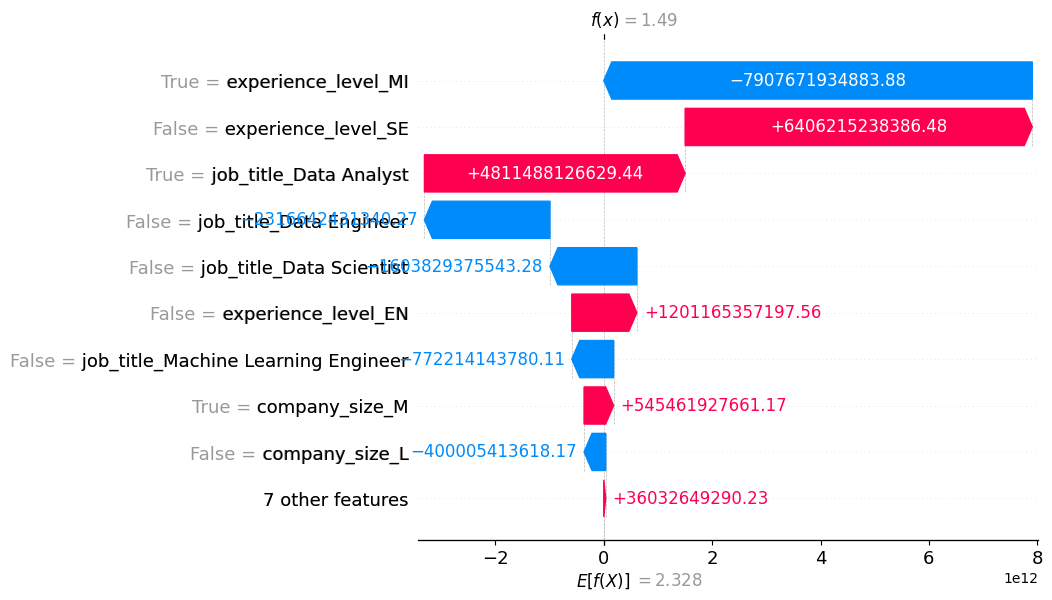

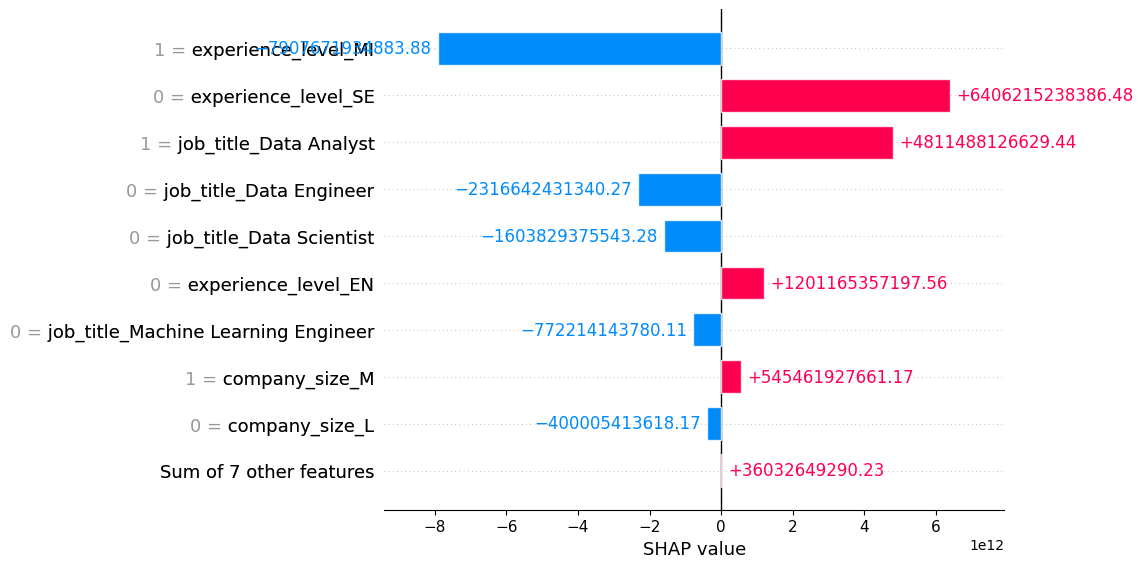

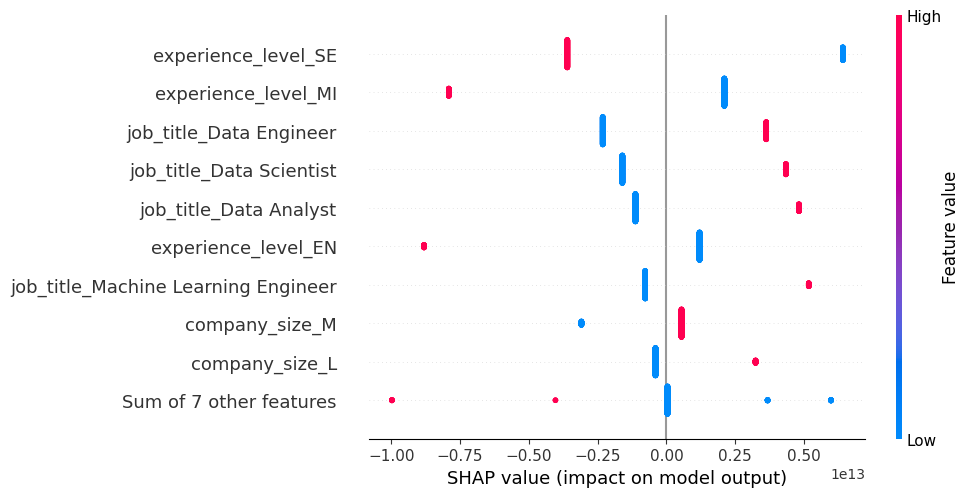

In [32]:
# prompt: Create the Waterfall plot for the SHAP values using the Linear Regression model

explainer = shap.Explainer(modelLinR, x_train)
shap_values = explainer(x_test)

shap.plots.waterfall(shap_values[23])

# shap.plots.push(shap_values[67])

shap.plots.bar(shap_values[23])

shap.plots.beeswarm(shap_values)



In [ ]:
shap.plots.force(shap_values[67], matplotlib = True)

In [ ]:
shap.plots.heatmap(shap_values)

---
---

## LIME

---
---

---
---

# HyperParameter / Fine Tuning the Model

sklearn.model_selection.GridSearchCV

In [ ]:
param_grid = {
    'n_estimators' : [50, 100, 250],
    'max_depth' : [5, 10, 30, None],
    'min_samples_split' : [2, 4],
    'max_features' : ['sqrt', 'log2']
}

grid_search_RFC = sklearn.model_selection.GridSearchCV(estimator =
                                                   sklearn.ensemble.RandomForestClassifier(),
                                                   param_grid = param_grid, verbose = 10
                                                   )

grid_search_GBC = sklearn.model_selection.GridSearchCV(estimator =
                                                   sklearn.ensemble.GradientBoostingClassifier(),
                                                   param_grid = param_grid, verbose = 10
                                                   )

In [ ]:
grid_search_RFC.fit(x_train,y_train)
grid_search_GBC.fit(x_train,y_train)

In [ ]:
grid_search_RFC.best_estimator_
grid_search_GBC.best_estimator_

In [ ]:
forest = grid_search_RFC.best_estimator_
boosting = grid_search_GBC.best_estimator_

In [ ]:
print(forest.score(x_test, y_test))
print(boosting.score(x_test, y_test))